In [17]:
using CSV, DataFrames, Plots
dat = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,vcat([2],4:(end-1))]
dat1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,3]
dat2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,end]
dat[:,2:end] .= log.(dat[:,2:end] .+ 1e-2)
dat[1:4,:]

Row,year,lat_36_00450,lat_36_00900,lat_36_01350,lat_36_01800,lat_36_02250,lat_36_02700,lat_36_03150,lat_36_03600,lat_36_04050,lat_36_04500,lat_36_05849,lat_36_06299,lat_36_06749,lat_36_07199,lat_36_07649,lat_36_08099,lat_36_08549,lat_36_08999,lat_36_09449,lat_36_09899,lat_36_10349,lat_36_10799,lat_36_11249,lat_36_11698,lat_36_12148,lat_36_12598,lat_36_13048,lat_36_13498,lat_36_13948,lat_36_14398,lat_36_14848,lat_36_15298,lat_36_15748,lat_36_16198,lat_36_16648,lat_36_17098,lat_36_17547,lat_36_17997,lat_36_18447,lat_36_19347,lat_36_19797,lat_36_20247,lat_36_20697,lat_36_21147,lat_36_21597
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1984,-2.43795,-1.9025,-3.84914,-2.52832,-2.81083,-4.36208,-3.05077,-2.64698,-2.078,-4.60517,-4.60517,-4.4405,-0.915513,-1.75641,-1.20027,-1.94119,-1.03678,-3.6812,-4.60517,-2.11977,-0.804252,-1.58474,-1.26537,-4.60517,-1.63233,-1.64554,-3.99349,-1.54454,-1.5023,-2.58547,-1.63941,-1.50151,-3.37547,-1.77406,-1.05368,-1.8842,-1.73123,-2.8656,-3.78178,-4.60517,-3.34028,-0.681664,-0.955537,-1.71432,-1.09559
2,1985,-0.800995,-0.0137745,-0.83556,-0.240423,-0.495683,-1.25267,-0.535848,-0.327685,-0.13533,-1.00457,-4.60517,-1.18451,-0.0618075,-0.0644594,-0.204018,-0.0798734,0.00995033,-0.143568,-2.46943,-0.270178,0.00995033,0.00995033,0.00995033,-0.360923,0.00995033,0.00995033,-0.972054,0.00995033,-0.0189833,0.00995033,0.00995033,-0.100928,-0.803451,-0.223033,-0.459067,-0.522358,-0.316985,-0.445064,-1.22421,-3.97851,0.00995033,0.00995033,0.00995033,0.00995033,0.00995033
3,1986,-1.80098,-0.83091,-1.09486,-0.365123,-1.0107,-1.4645,-0.744626,-1.55959,-1.72477,-3.80866,-4.60517,-3.27246,-1.5777,-1.87296,-1.83918,-1.09126,-1.98384,-1.46933,-4.07004,-1.38429,-1.06248,-0.923027,-0.944995,-4.2058,-1.92127,-1.7083,-2.88632,-1.65098,-1.98705,-1.68482,-0.840014,-1.78871,-3.57587,-2.22096,-1.06171,-2.03188,-1.18065,-1.0208,-0.732183,-1.65437,-1.36028,-1.4828,-2.29586,-1.45745,-2.77032
4,1987,-0.817995,-0.640768,-1.0418,-0.291619,-0.977762,-1.07758,-0.639388,-1.05079,-1.25423,-2.63243,-4.60517,-2.13682,-0.625342,-0.879395,-0.796447,-0.757462,-0.825752,-2.17458,-3.33211,-1.30186,-0.760597,-0.94546,-1.07241,-1.57449,-1.05118,-1.04158,-2.51289,-1.23411,-1.34993,-1.25475,-0.864295,-0.919857,-4.20464,-1.1366,-0.550202,-0.548903,-0.84814,-0.67096,-0.173496,-0.579667,-0.618157,-0.589606,-0.49708,-0.816267,-1.35927


In [18]:
dat_K = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,4:(end-1)]
K1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,3]
K2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,end]
K = Matrix(dat_K)[1,:]
K

45-element Vector{Float64}:
 0.174105861214001
 0.687939289908754
 1.0
 0.358026922034511
 0.361700846207125
 0.270952911534717
 0.337509159715321
 0.120534826994308
 0.114090402625952
 0.00942170827435982
 ⋮
 0.0294435912106885
 0.0336093795484888
 0.0274118910671445
 0.0231196233725821
 0.0111663203541422
 0.296644281828129
 0.142190903524357
 0.11825016813724
 0.105016010680479

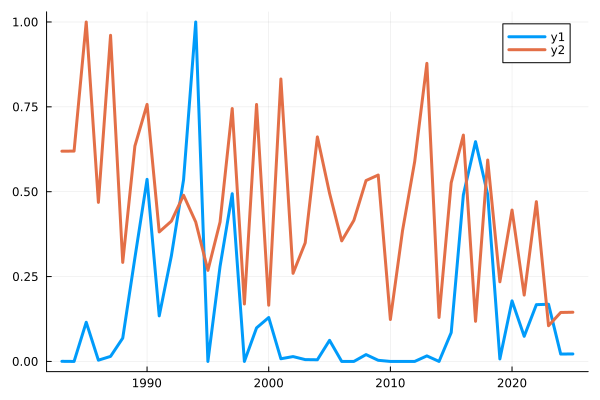

In [19]:
using Statistics
mu_t1 = dat1
mu_t1 = vcat([mean(mu_t1)],mu_t1,[mean(mu_t1)])
years = vcat([1500],dat.year, [2500])

mu_t2 = dat2
mu_t2 = vcat([mean(mu_t2)],mu_t2,[mean(mu_t2)])
years = vcat([1500],dat.year, [2500])

function mu(t,mu_t)
    ind_lower = maximum(eachindex(years)[years .<= t])
    ind_upper = minimum(eachindex(years)[years .> t])
    t_lower = years[ind_lower]
    t_upper = years[ind_upper]
    mu_lower = mu_t[ind_lower]
    mu_upper = mu_t[ind_upper]

    mu = mu_lower + (t-t_lower)/(t_upper-t_lower)*(mu_upper-mu_lower)
    return mu
end 
tvals = 1983:0.25:2025
Plots.plot(tvals, broadcast(t ->mu(t,mu_t1), tvals), linewidth = 3)
Plots.plot!(tvals, broadcast(t ->mu(t,mu_t2), tvals), linewidth = 3)

In [21]:
X = CSV.read("../processed_data/covars.csv",DataFrame)[:,:2:end]
X[1:4,:]

Row,year,variable,value
,Float64,String7,Float64
1,1980.0,enso,0.33
2,1980.08,enso,0.2
3,1980.17,enso,0.39
4,1980.25,enso,0.51


In [22]:
include("../src/UDE2.jl")
model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1,[2];hidden = 10)
nothing

In [46]:
function training!(model,reg_weight)
α = UniversalDiffEq.train!(model, loss_function = "spline gradient matching", regularization_weight = reg_weight, 
        optim_options = (maxiter = 1500, step_size = 0.025), loss_options = (σ = 0.05^2, τ = 0.2^2, T = 160))
end
training!(model,1e5)
nothing

162
1.269781021124e9 1.245744581678e9 1.221826578638e9 1.198123006353e9 1.174771454139e9 1.151976852284e9 1.129952871961e9 1.108766572256e9 1.08819252717e9 1.067996400856e9 1.048107954866e9 1.02851774877e9 1.009230071382e9 9.9026667615e8 9.71665490717e8 9.5346330576e8 9.35660637667e8 9.1818761185e8 9.00948406765e8 8.83933345677e8 8.67227515579e8 8.50916403992e8 8.3498245511e8 8.19318808186e8 8.03880335723e8 7.88744646634e8 7.74007128679e8 7.59611105189e8 7.45420725656e8 7.31480562786e8 7.17905236752e8 7.04651210396e8 6.9160821409e8 6.7880624622e8 6.6632632383e8 6.54110559077e8 6.42083001019e8 6.30313738538e8 6.18832525571e8 6.07551787457e8 5.96478439751e8 5.85673914996e8 5.75081333418e8 5.64669263948e8 5.54496550847e8 5.44535953706e8 5.3474480065e8 5.25171667178e8 5.15796322117e8 5.06583845681e8 4.9757114088e8 4.88743276001e8 4.80072933819e8 4.715902118e8 4.63273617481e8 4.55108786025e8 4.47118198383e8 4.39277758955e8 4.31586767595e8 4.24055955281e8 4.16662246166e8 4.09415246574e8 4.02

In [47]:
using JLD2
save_object("../results/parameters/model2_0.2_1e5.jld",model.parameters)

In [48]:
rhs = UniversalDiffEq.get_right_hand_side(model)
f_rhs = (u,X,site) -> rhs(zeros(length(K)) .+ u  , [X,X], 2000.0)[site]
f_rhs(0.0,0.0,2)

-0.9232909877501466

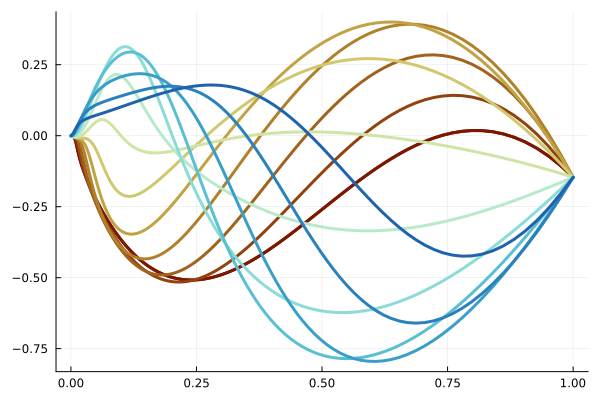

In [54]:
Xvals = -3:0.5:3; site = 15
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp.(uvals).*f_rhs.(uvals,Xvals[1],site), color = colors[1], label = "",width=3)
i = 0
for X in Xvals
    i += 1
    Plots.plot!(p1,exp.(uvals),exp.(uvals).*f_rhs.(uvals,X,site), color = colors[i], label = "",width=3)
end
p1

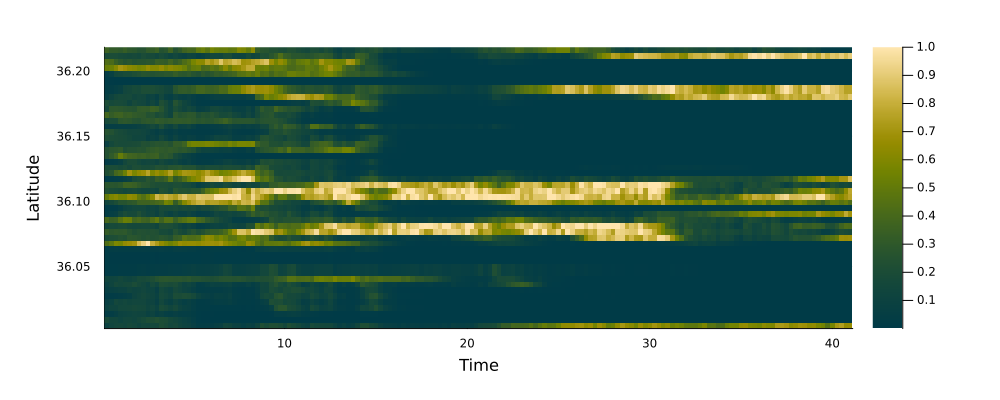

In [63]:
u = model.parameters.uhat[:,1]
X = [0.0,0.0] .+ -2.0
T = 2025-1984
dt = 0.25
uvals = zeros(length(K), round(Int,T/dt))
i = 0
for t in (1984+dt):dt:2025
    i+=1
    u[u.>0] .= 0
    uvals[:,i] = u
    X = model.process_model.covariates(t)
    u = u + dt*rhs(u,X,t).+sqrt(dt)*0.2*randn(length(K))
end

function get_latitude(nm)
m = match(r"(?<integer>\d+)_(?<decimal>\d+)",nm)
parse(Float64,(m[:integer])) + parse(Float64,(string("0.",m[:decimal])))
end 

lats = get_latitude.(names(dat[:,2:end]))

using Plots.PlotMeasures
Plots.heatmap(dt:dt:T,lats,exp.(uvals), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

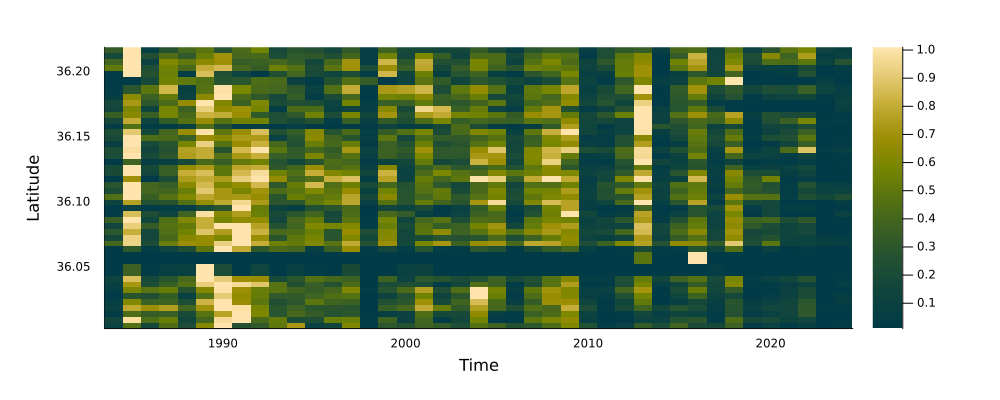

In [64]:
Plots.heatmap(dat.year,lats,exp.(Matrix(dat[:,2:end]))', c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

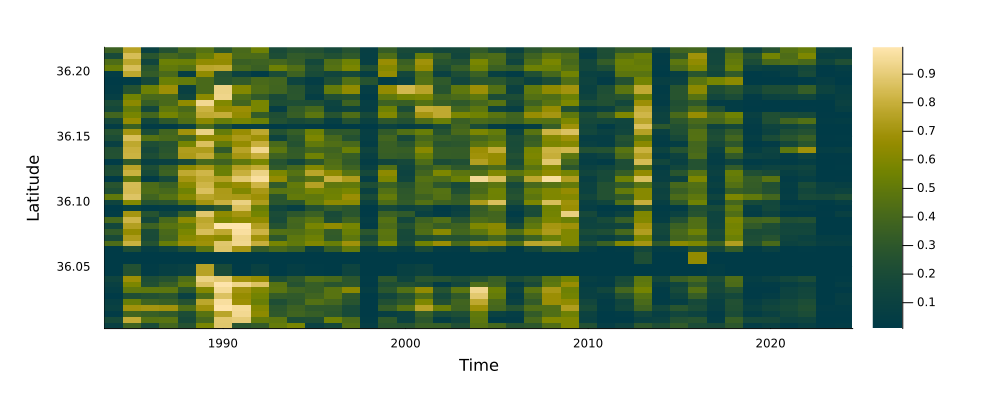

In [65]:
Plots.heatmap(dat.year,lats,exp.(Matrix(model.parameters.uhat)), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)